In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dacon/emotional_textmining_NLP/

/content/drive/MyDrive/dacon/emotional_textmining_NLP


In [ ]:
import numpy as np
import pandas as pd
import seaborn as snss
import matplotlib.pyplot as plt
import os

def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file)
        print(prefix + path)

if __name__ == "__main__":
    root_dir = "./data/"
    print_files_in_dir(root_dir, "")

./data/val.txt
./data/train.txt
./data/test.txt


In [ ]:
train = pd.read_csv("./data/train.txt", sep=";", names=["Description", "Emotion"])
test = pd.read_csv("./data/test.txt", sep=";", names=["Description", "Emotion"])
validate = pd.read_csv("./data/val.txt", sep=";", names=["Description", "Emotion"])

In [ ]:
print(train.shape)
print(test.shape)
print(validate.shape)

(16000, 2)
(2000, 2)
(2000, 2)


In [ ]:
train.head()

,Description,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
def describe_data(data_type, data, label):
    print(data_type, "Description")
    size = data.shape
    null_values = data.isnull().sum().sum()
    label_count = data[label].value_counts()
    print("==========================")
    print(data_type, " shape:", size, "\n")
    print(data_type, " contains:", null_values, "null values \n")
    print("label counts : \n", label_count)
    print()
    sns.countplot(data=data, x=label, order=list(sorted(set(train["Emotion"]))))




train data Description
train data  shape: (16000, 2) 

train data  contains: 0 null values 

label counts : 
 joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64



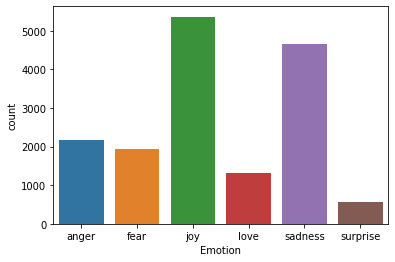

In [ ]:
describe_data("train data", train, "Emotion")

validate data Description
validate data  shape: (2000, 2) 

validate data  contains: 0 null values 

label counts : 
 joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64



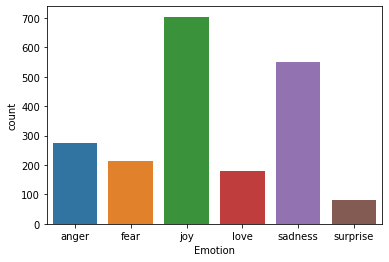

In [ ]:
describe_data("validate data", validate, "Emotion")

test data Description
test data  shape: (2000, 2) 

test data  contains: 0 null values 

label counts : 
 joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64



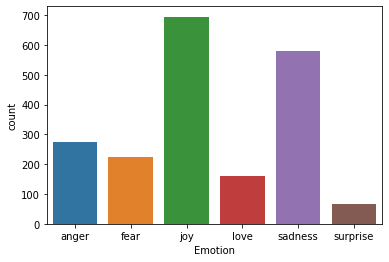

In [ ]:
describe_data("test data", test, "Emotion")

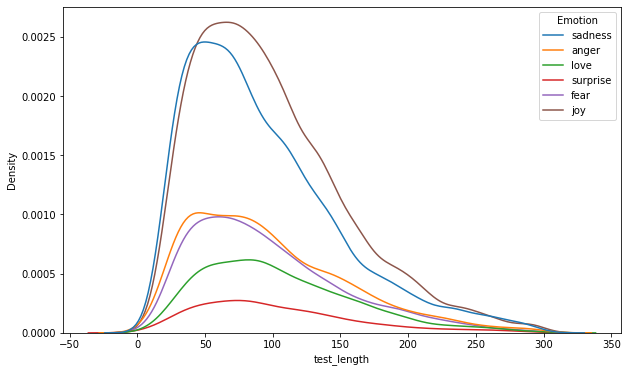

In [ ]:
train["test_length"] = train["Description"].apply(len)

fig = plt.figure(figsize=(10,6))

sns.kdeplot(x=train["test_length"], hue=train["Emotion"])
plt.show()

In [ ]:
train[["test_length"]].describe()

,test_length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


In [ ]:
def label_encode(data, label):
    labels = data[label].map(
        {
            "joy" : 0,
            "sadness":1,
            "anger":2,
            "fear":3,
            "love":4,
            "surprise":5
        }
    )
    return labels

In [ ]:
train["label"] = label_encode(train, "Emotion")
validate["label"] = label_encode(validate, "Emotion")
test["label"] = label_encode(test, "Emotion")

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
vocab_size = 10000
sentence_len = 150

In [ ]:
def data_preparation(data, description):
    # 어간 추출 알고리즘으로 porter stemmer 사용
    stemmer = PorterStemmer()
    corpus = []

    for text in data[description]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()

        # porter stemmer로 불용어 제거하여 형태소 분석
        text = [stemmer.stem(words)
                for words in text
                if words not in stopwords.words("english")]
        text = " ".join(text)
        corpus.append(text)

        # vocabulary size를 10,000으로 one_hot 인코딩
        oneHot_doc = [one_hot(input_text=words, n=vocab_size)
                      for words in corpus]

        # 최대 150 길이로 embedding
        embedded_doc = pad_sequences(sequences=oneHot_doc,
                                     maxlen=sentence_len,
                                     padding="pre")
    return embedded_doc

In [ ]:
# 오래 걸림..
X_train = data_preparation(train, "Description")
X_validate = data_preparation(validate, "Description")
X_test = data_preparation(test, "Description")

In [ ]:
# 저장해서 사용
# np.save('./data/x_train', X_train)
# np.save('./data/x_validate', X_validate)
# np.save('./data/x_test', X_test)

In [ ]:
y_train = train["label"]
y_validate = validate["label"]
y_test = test["label"]

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=hp.Int("output_dim",
                              min_value=40,
                              max_value=120,
                              step=10),
            input_length=sentence_len
        )
    )

    model.add(LSTM(units=128))

    for j in range(hp.Int("Dense Layers",
                          min_value=1,
                          max_value=5,
                          step=1)):
        model.add(Dense(units=hp.Int("units_"+str(j),
                                     min_value=32,
                                     max_value=256,
                                     step=32),
                        activation="relu",
                        kernel_initializer=hp.Choice(
                            "kernel_init"+str(j),
                            values=["he_uniform", "he_normal"]
                        )))

    model.add(Dense(units=6,
                    activation="softmax"))

    model.compile(optimizer=Adam(
                    learning_rate=hp.Choice("learnRate",
                                             values=[0.01, 0.001, 0.0001])),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [ ]:
# !pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 20.7 MB/s 
     |████████████████████████████████| 1.6 MB 39.2 MB/s 


In [ ]:
from kerastuner.tuners import RandomSearch

<ipython-input-46-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
tuner = RandomSearch(build_model,
                     objective="val_accuracy",
                     max_trials=2,
                     executions_per_trial=2,
                     )

In [ ]:
tuner.search(X_train,
             y_train,
             validation_data=(X_validate,
                             y_validate),
             epochs=3
             )


Trial 2 Complete [00h 00m 43s]
val_accuracy: 0.6545000076293945

Best val_accuracy So Far: 0.6545000076293945
Total elapsed time: 00h 01m 46s


In [ ]:
model=tuner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 110)          1100000   
                                                                 
 lstm (LSTM)                 (None, 128)               122368    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,247,526
Trainable params: 1,247,526
Non-trainable params: 0
_________________________________________________________________


## model evaluation

In [ ]:
predict_classes=model.predict(X_test)

63/63 [==============================] - 1s 8ms/step


In [ ]:
y_pred=[np.argmax(label) for label in predict_classes]

In [ ]:
predict=pd.DataFrame(
    y_pred,
    columns=["Predicted"]
)

In [ ]:
predict["Predicted Label"]=predict["Predicted"].map(
    {
        0:"joy",
        1:"sadness",
        2:"anger",
        3:"fear",
        4:"love",
        5:"surprise"
    }
)

In [ ]:
predict_df=pd.concat([test["Description"],
                      test["Emotion"],
                      predict["Predicted Label"]],
                    axis=1)

In [ ]:
predict_df.sample(10)

,Description,Emotion,Predicted Label
279,i think we were both feeling a little drained ...,sadness,sadness
1076,ive been too deep down in the swamps swimming ...,sadness,sadness
1237,i get paid too much because i get so many deli...,sadness,sadness
1209,i was really struggling to run with the discom...,joy,joy
724,i can put on it without words since i just can...,anger,anger
1928,i feel inside cause life is like a game someti...,fear,fear
1729,i felt like id developed feelings for this guy...,joy,joy
1453,i would really love to be with him but not as ...,sadness,sadness
701,i feel assured that the guns are locked away i...,joy,joy
404,i feel like breathing is as delicate as dried ...,love,love


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print("Test Score:{:.2f}%".format(score*100))

Test Score:72.25%


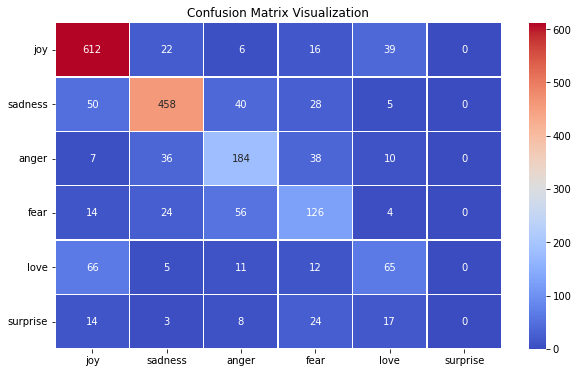

In [ ]:
labels = ["joy", "sadness", "anger", "fear", "love", "surprise"]
fig = plt.figure(figsize=(10,6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            xticklabels=labels,
            yticklabels=labels,
            cmap="coolwarm",
            linewidths=0.5
           )
plt.title("Confusion Matrix Visualization")
plt.yticks(rotation=0)
plt.show()